#### 1 Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
#### 2 Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
#### 3 Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
#### 4 Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
#### 5 Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)
#### 6 Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from sklearn.model_selection import RandomizedSearchCV

Читаем базу my_PJME_MW.csv

In [2]:
data = pd.read_csv('data/my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Делаем ресекмплинг по неделям

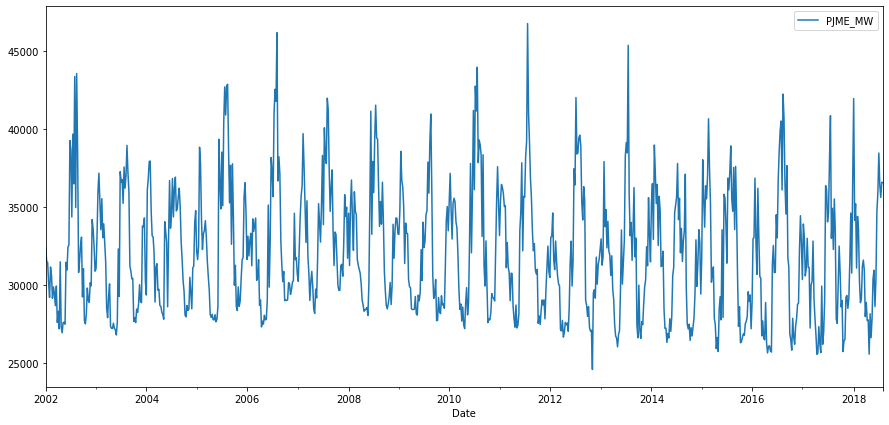

In [4]:
plt.figure(figsize=(15, 7))
data_w = data.copy().resample('W').mean()
data_w['PJME_MW'].plot(label='PJME_MW')
plt.legend(loc='best')
plt.show()

Убираем признаки у которых интервал меньше недели

In [5]:
data_w = data_w.drop(columns=['dayofmonth','dayofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'])
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 5 columns):
PJME_MW       866 non-null float64
year          866 non-null float64
month         866 non-null float64
quarter       866 non-null float64
weekofyear    866 non-null float64
dtypes: float64(5)
memory usage: 40.6 KB


In [6]:
def split_data( data, koeff = None, test_count = None ):
    if koeff is None and test_count is None:
        raise ValueError(f'the separator is not filled')
    elif (koeff is not None):
        last_train_date = data.index.min() + timedelta(7*int(data.shape[0]*(1-koeff)))
    else:
        last_train_date = data.index.max() - timedelta(7*test_count)

    return data.loc[data.index <= last_train_date].copy(), \
           data.loc[data.index >  last_train_date].copy(), \
           last_train_date

Разделение мадели на test and train

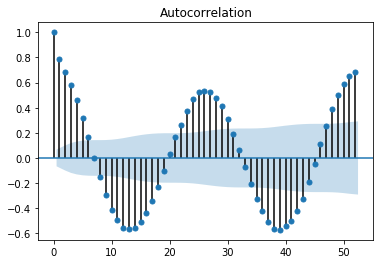

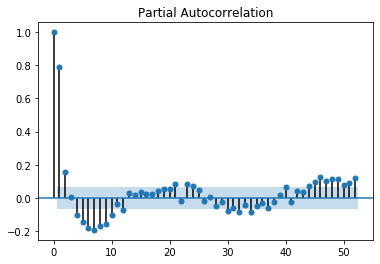

In [7]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=52)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=52)
plt.show()

In [8]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

In [9]:
data_w['13w']=data_w['PJME_MW'].rolling(window=13).mean()
data_w['6w']=data_w['PJME_MW'].rolling(window=6).mean()
data_w['26w']=data_w['PJME_MW'].rolling(window=26).mean()

In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_09'] = exponential_smoothing(data_w['PJME_MW'], 0.09)
data_w['exp_0_11'] = exponential_smoothing(data_w['PJME_MW'], 0.11)

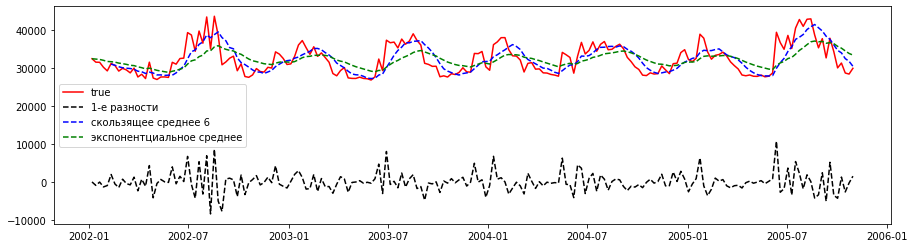

In [11]:
N100=200
plt.figure(figsize=(15, 4))
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='true')
plt.plot(data_w.index[:N100],data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_w.index[:N100],data_w['6w'][:N100],'--b',label ='скользящее среднее 6')
plt.plot(data_w.index[:N100],data_w['exp_0_11'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

In [12]:
p = 27 # длительность цикла 27 точек
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor

def find_best_features(df, h,  p, count_feats=5):
    scl_target=StandardScaler()
    scl_x=StandardScaler()
    target = df['PJME_MW'].values[h+p:].reshape((df.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)
    

    X = df.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))

    sfk =SelectKBest(f_regression, k=count_feats)
    X_new1 = sfk.fit_transform(X, y.ravel())
    print(f'SelectKBest:{df.columns[sfk.get_support()]}')

    sfp=SelectPercentile(f_regression, percentile=20)
    X_new2 = sfp.fit_transform(X, y.ravel())
    print(f'SelectPercentile20:{df.columns[sfp.get_support()]}')
          
    gr_model = GradientBoostingRegressor().fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 5)

    sfm.fit(X, y.ravel())
    X_new3 = sfm.transform(X)
    print(f'SelectFromModel:{df.columns[sfm.get_support()]}')
    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]

    print('Номера признаков k лучших признаков : ',list_param_k)
    print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
    print('Номера признаков для выбора по модели : ',list_param_m)
    mergedlist = [*list_param_k, *list_param_p, *list_param_m]
    list_par= list(data_w.columns[list(set(mergedlist))])
    list_par.sort()
    return list_par

In [15]:
h = 4
list_par = find_best_features(data_w.copy(), h, p, 5)

SelectKBest:Index(['t23', 't22', 't10', 't9', 't8'], dtype='object')
SelectPercentile20:Index(['PJME_MW', 't25', 't24', 't23', 't22', 't21', 't20', 't12', 't11',
       't10', 't9', 't8', 't7', 't6'],
      dtype='object')
SelectFromModel:Index(['month', 't23', 't22', 't9', 't8'], dtype='object')
Номера признаков k лучших признаков :  [19 20 32 33 34]
Номера признаков лучших признаков по процентной форме:  [ 0 17 18 19 20 21 22 30 31 32 33 34 35 36]
Номера признаков для выбора по модели :  [ 2 19 20 33 34]


In [16]:
scl_target4 =StandardScaler()
scl_x4 =StandardScaler()

train, test, days_delta = split_data(data_w[list_par], test_count=100+h+p)
X = scl_x4.fit_transform(data_w[list_par].iloc[p:-h,:].astype('float64'))
y = scl_target4.fit_transform(data_w['PJME_MW'].values[h+p:].reshape((data_w['PJME_MW'].shape[0]-h-p,1)))
X_train_4 = X[:train.shape[0],:]
y_train_4 = y[:train.shape[0],0]
X_test_4 =  X[train.shape[0]:,:]
y_test_4 =  y[train.shape[0]:,0]
X_train_4.shape, y_train_4.shape, X_test_4.shape, y_test_4.shape

((735, 15), (735,), (100, 15), (100,))

In [17]:
def get_random_search(X_train, y_train):
    param_dist = {"max_depth": range(1, 100, 1), 
                "n_estimators":range(10, 800, 10)}

    #  randomized search
    n_iter_search = 10

    model_gr =GradientBoostingRegressor()

    random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

    random_search.fit(X_train, y_train)

    report(random_search.cv_results_)
    return random_search

random_search = get_random_search(X_train_4, y_train_4)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Model with rank: 1
Mean validation score: 0.508 (std: 0.086)
Parameters: {'n_estimators': 200, 'max_depth': 8}

Model with rank: 2
Mean validation score: 0.366 (std: 0.120)
Parameters: {'n_estimators': 120, 'max_depth': 12}

Model with rank: 3
Mean validation score: 0.305 (std: 0.138)
Parameters: {'n_estimators': 540, 'max_depth': 34}



In [18]:
model4_g_best = GradientBoostingRegressor(max_depth=random_search.best_params_['max_depth'],  n_estimators=random_search.best_params_['n_estimators'])
model4_g_best.fit( X_train_4, y_train_4 ) 
y_test_4_pred_g = model4_g_best.predict(X_test_4)
er_g = mean_absolute_percentage_error(y_true=scl_target4.inverse_transform( y_test_4), y_pred = scl_target4.inverse_transform( y_test_4_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.611671665110091 %


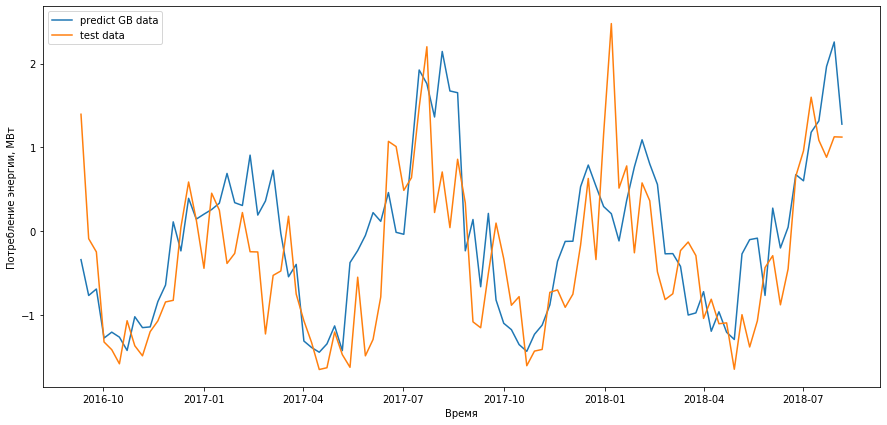

In [19]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_4_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test_4, label='test data')

plt.legend()
plt.show()

In [20]:
h = 1
list_par = find_best_features(data_w.copy(), h, p, 5)

SelectKBest:Index(['PJME_MW', '6w', 't12', 't2', 't1'], dtype='object')
SelectPercentile20:Index(['PJME_MW', '6w', 't27', 't26', 't25', 't24', 't23', 't14', 't13', 't12',
       't11', 't10', 't2', 't1'],
      dtype='object')
SelectFromModel:Index(['PJME_MW', 't26', 't11', 't9', 't1'], dtype='object')
Номера признаков k лучших признаков :  [ 0  7 30 40 41]
Номера признаков лучших признаков по процентной форме:  [ 0  7 15 16 17 18 19 28 29 30 31 32 40 41]
Номера признаков для выбора по модели :  [ 0 16 31 33 41]


In [21]:
train, test, days_delta = split_data(data_w[list_par], test_count=100+h+p)
scl_target=StandardScaler()
scl_x=StandardScaler()
X = scl_x.fit_transform(data_w[list_par].iloc[p:-h,:].astype('float64'))
y = scl_target.fit_transform(data_w['PJME_MW'].values[h+p:].reshape((data_w['PJME_MW'].shape[0]-h-p,1)))
X_train_1 = X[:train.shape[0],:]
y_train_1 = y[:train.shape[0],0]
X_test_1 =  X[train.shape[0]:,:]
y_test_1 =  y[train.shape[0]:,0]
X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((738, 15), (738,), (100, 15), (100,))

In [22]:
random_search = get_random_search(X_train_1, y_train_1)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Model with rank: 1
Mean validation score: 0.630 (std: 0.085)
Parameters: {'n_estimators': 690, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.509 (std: 0.066)
Parameters: {'n_estimators': 540, 'max_depth': 13}

Model with rank: 3
Mean validation score: 0.499 (std: 0.059)
Parameters: {'n_estimators': 10, 'max_depth': 96}



In [23]:
model1_g_best = GradientBoostingRegressor(max_depth=random_search.best_params_['max_depth'],  n_estimators=random_search.best_params_['n_estimators'])
model1_g_best.fit( X_train_1, y_train_1 ) 
y_test_1_pred_g = model1_g_best.predict(X_test_1)
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_1), y_pred = scl_target.inverse_transform( y_test_1_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.725171436359753 %


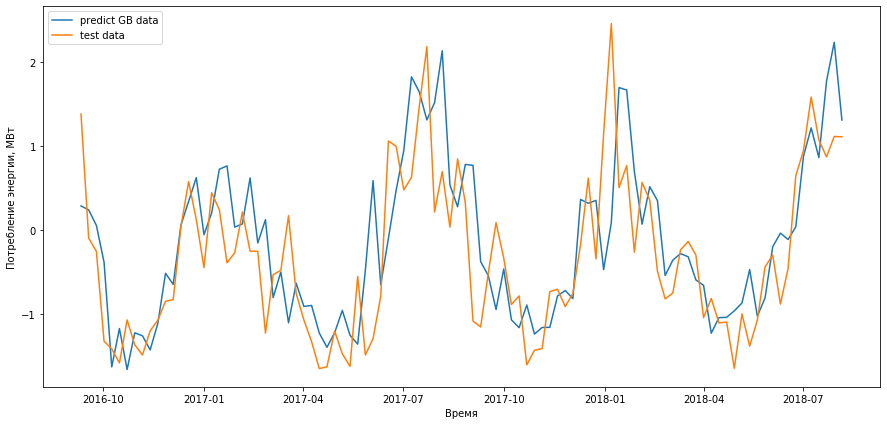

In [24]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_1_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test_1, label='test data')

plt.legend()
plt.show()

In [25]:
X_test_100 = X_test_1.copy()
y_test_100 = y_test_1_pred_g.copy()

N10=4
for i in range(N10+1):
    y_test_100[i] = model1_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
      # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1])
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #строим 'd_w4' - признак под номером 2
    if i>=4:
        X_test_100[i+1,2] = np.mean(X_test_100[i-4+1:i,0])   
    if i>=1:
        X_test_100[i+1,3] = X_test_100[i-1+1,0]     
    if i>=2:
        X_test_100[i+1,4] = X_test_100[i-2+1,0]  
    if i>=3:
        X_test_100[i+1,5] = X_test_100[i-3+1,0]  
    if i>=7:
        X_test_100[i+1,6] = X_test_100[i-7+1,0]   
    X_test_100[i+1,1] = (np.log((y_i))-scl_x.mean_[6])*scl_x.scale_[6]

In [26]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_1[:N10]),y_pred = scl_target.inverse_transform( y_test_100[:N10]))
print('ошибка градиентного бустинга MAPE c :  ', er_g,'%')

ошибка градиентного бустинга MAPE c :   8.959331589262511 %


In [27]:
er_g = mean_absolute_percentage_error(y_true=scl_target4.inverse_transform( y_test_4[:N10]), y_pred = scl_target4.inverse_transform( y_test_4_pred_g[:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   8.284556999391297 %


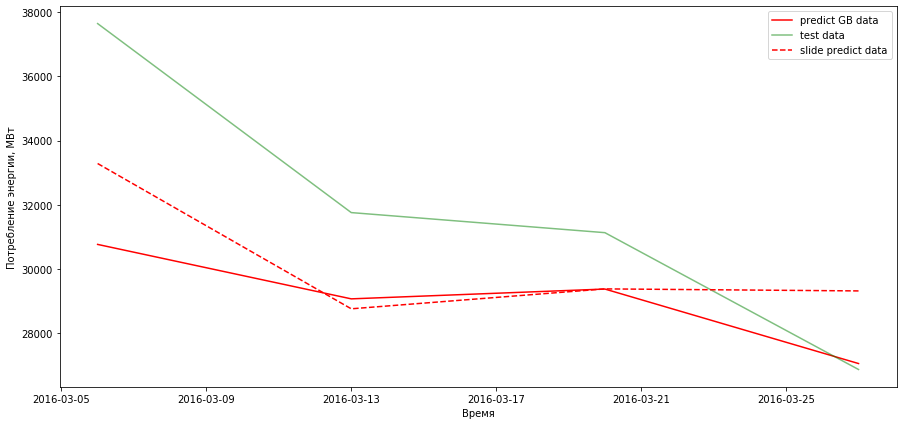

In [28]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],scl_target4.inverse_transform(y_test_4_pred_g[:N10]), 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],scl_target.inverse_transform(y_test_1[:N10]), 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],scl_target.inverse_transform(y_test_100[:N10]), '--r',label='slide predict data')

plt.legend()
plt.show()  

In [29]:
X_test_100 = X_test_1.copy()
y_test_100 = y_test_1_pred_g.copy()

arr_er_g = {'Интервал':[],'НИТ':[]}
N10=100
for i in range(N10):
    y_test_100[i] = model1_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1])
    if i < y_test_100.shape[0]-1:
        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
        #строим 'd_w4' - признак под номером 2
        if i>=4:
            X_test_100[i+1,2] = np.mean(X_test_100[i-4+1:i,0])   
        if i>=1:
            X_test_100[i+1,3] = X_test_100[i-1+1,0]     
        if i>=2:
            X_test_100[i+1,4] = X_test_100[i-2+1,0]  
        if i>=3:
            X_test_100[i+1,5] = X_test_100[i-3+1,0]  
        if i>=7:
            X_test_100[i+1,6] = X_test_100[i-7+1,0]   
        X_test_100[i+1,1] = (np.log((y_i))-scl_x.mean_[6])*scl_x.scale_[6]
    if i % 10 == 9:
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test_1[i-9:i]),y_pred = scl_target.inverse_transform( y_test_100[i-9:i]))
        arr_er_g['Интервал'].append(er_g)
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test_1[:i]),y_pred = scl_target.inverse_transform( y_test_100[:i]))
        arr_er_g['НИТ'].append(er_g)


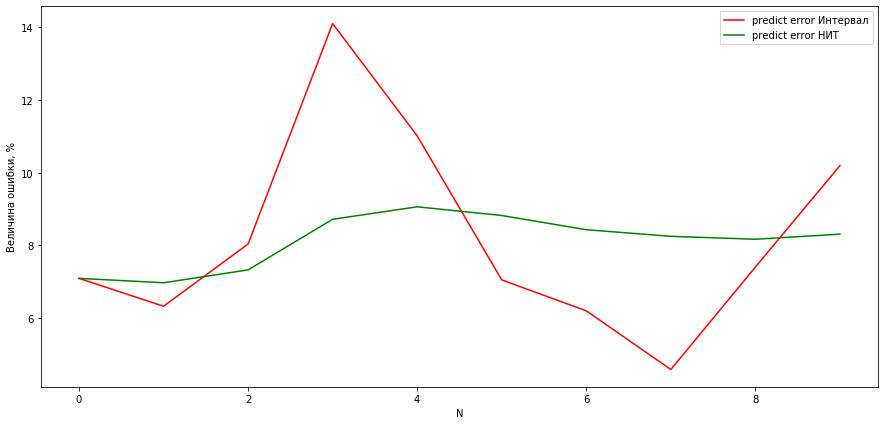

In [30]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('N')
plt.ylabel('Величина ошибки, %')
i = range(len(arr_er_g['Интервал']))
plt.plot(i ,arr_er_g['Интервал'], 'r',label='predict error Интервал' )
plt.plot(i ,arr_er_g['НИТ'], 'g',label='predict error НИТ' )
plt.legend()
plt.show()

Вывод: Ошибка при увеличении горизонта прогноза возрастает. При этом наблюдаются скачки - резкое увеличение значения относительной ошибки. Выероятно из-за сезонности мы имеем скачки при увеличении горизонта прогнозирования

In [31]:
!telegram-send "Расчет MLB-04 закончен"